In [1]:
import json
import glob
import time
import pickle
import random
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xml.etree.ElementTree as et 
import warnings
import itertools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
plt.rcParams['figure.figsize'] = (20.0, 10.0)
plt.rcParams.update({'font.size': 16})
plt.style.use('ggplot')

In [2]:
def iter_docs(author):
    author_attr = author.attrib
    for doc in author.iter('vehicle'):
        doc_dict = author_attr.copy()
        doc_dict.update(doc.attrib)
        #doc_dict['data'] = doc.text
        yield doc_dict

In [3]:
def iter_author(etree):
    for author in etree.iter('timestep'):
        for row in iter_docs(author):
            yield row

In [4]:
input_files = glob.glob("*.xml")[4:14]
input_files

['here.output0.xml',
 'here.output1.xml',
 'here.output2.xml',
 'here.output3.xml',
 'here.output4.xml',
 'here.output5.xml',
 'here.output6.xml',
 'here.output7.xml',
 'here.output8.xml',
 'here.output9.xml']

In [5]:
dates = pd.date_range(start="2022-02-28",end="2022-03-09")

clusters = pd.read_pickle('clusters_20.pkl')
dic = {str(clusters[i][j]):i for i in range(len(clusters)) for j in range(len(clusters[i]))}

df = pd.DataFrame()
for i in range(10):
    data = et.parse(input_files[i])
    df1 = pd.DataFrame(list(iter_author(data)))
    df1['time'] = df1['time'].astype('float')
    df1['time'] = df1['time'].astype('int')
    df1['seg0'] = df1['lane'].str.split('to').str[0]
    df1['seg1'] = df1['lane'].str.split(':n').str[1].str.split('_').str[0]
    df1['seg'] = df1['seg1'].fillna(df1['seg0'])
    df1['cl'] = df1['seg'].map(dic)
    df1['cl'] = df1['cl'].astype('int')
    df2 = pd.DataFrame()
    for t in df1['time'].unique():
        df2[t] = df1[df1['time']==t]['cl'].value_counts().reindex(list(range(0,len(clusters))),fill_value=0)
    df2 = df2.T
    df2.index = [str(dates[i])+" "+str(datetime.timedelta(seconds = index)) for index in df2.index]
    df2.index = pd.to_datetime(df2.index)
    if i== 0:
        df = df2
    else:
        df = pd.concat([df, df2])

df_re = df.resample('H').max()

Text(0.5, 0, 'Time')

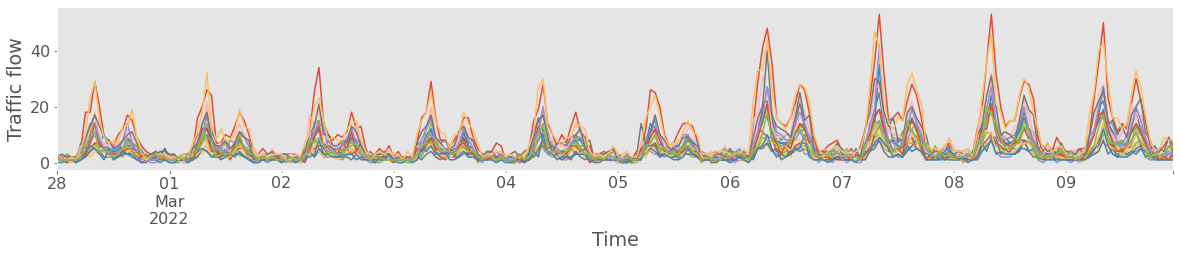

In [6]:
plt.rcParams.update({'font.size': 16})
plt.rcParams["figure.figsize"] = (20,3)
df_re.plot(legend=None)
plt.grid()
plt.ylabel('Traffic flow')
plt.xlabel('Time')
# xlim = np.arange(0, 60* 60 *24, 60*60*4)
# plt.xticks(xlim, [str(n).zfill(2) + ':00' for n in np.arange(0, 24, 4)])

In [8]:
# Define the d and q parameters to take any value between 0 and 1
q = d = range(1, 2)
# Define the p parameters to take any value between 0 and 3
p = range(3, 4)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
seasonal_pdq = [(x[0], x[1], x[2], 24) for x in list(itertools.product(p, d, q))]

# print('Examples of parameter combinations for Seasonal ARIMA...')
# print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
# print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
# print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))

In [9]:
train_set = df_re['2022-02-28':'2022-03-08']
test_set = df_re['2022-03-09':'2022-03-09']

In [10]:
train_set

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
2022-02-28 00:00:00,3,2,1,2,1,1,1,1,1,1,1,1,1,1,2,0,3,2,3,1
2022-02-28 01:00:00,1,1,1,1,3,1,2,1,1,1,1,0,1,3,1,0,2,3,1,1
2022-02-28 02:00:00,3,1,1,2,1,0,1,0,1,0,0,1,3,1,1,1,2,2,1,1
2022-02-28 03:00:00,2,2,1,1,1,1,0,1,1,1,1,0,1,2,1,1,1,2,2,1
2022-02-28 04:00:00,2,1,1,1,1,0,1,0,1,0,0,1,2,2,1,0,1,2,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-03-08 19:00:00,4,2,0,3,2,2,3,1,4,2,2,1,2,3,3,1,3,6,5,3
2022-03-08 20:00:00,7,2,1,3,2,1,4,2,3,2,2,1,2,5,2,1,2,4,7,2
2022-03-08 21:00:00,4,3,2,5,4,1,3,2,3,1,2,3,4,4,2,1,3,5,4,2
2022-03-08 22:00:00,9,3,0,5,2,3,6,2,3,3,1,2,5,5,3,1,4,3,5,3


In [11]:
test_set

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
2022-03-09 00:00:00,4,3,1,2,2,1,3,1,1,2,1,1,3,3,2,1,2,3,3,2
2022-03-09 01:00:00,4,2,0,4,2,1,2,1,2,1,1,2,3,4,2,1,2,4,3,4
2022-03-09 02:00:00,4,3,1,1,1,1,4,1,2,1,1,2,2,4,1,1,1,3,2,1
2022-03-09 03:00:00,5,3,0,2,4,1,4,1,2,1,1,0,3,2,1,1,2,5,3,2
2022-03-09 04:00:00,5,2,1,3,1,1,4,1,2,3,2,1,4,4,2,1,4,2,4,2
2022-03-09 05:00:00,10,5,2,7,3,4,10,3,5,6,2,5,6,5,6,2,10,9,17,4
2022-03-09 06:00:00,23,11,4,10,3,6,12,5,11,12,3,5,10,11,10,5,11,18,25,6
2022-03-09 07:00:00,36,15,9,20,5,7,25,8,17,14,4,9,17,21,17,6,20,22,40,13
2022-03-09 08:00:00,50,19,7,22,9,10,28,14,27,18,8,14,16,26,18,12,26,26,43,17
2022-03-09 09:00:00,23,9,6,14,8,9,16,7,14,11,3,6,12,12,12,6,14,14,29,7


In [12]:
def SARIMA(train_data, test_data):
    # Train the model
    warnings.filterwarnings("ignore") # specify to ignore warning messages
    time0 = time.time()
    AIC = []
    SARIMAX_model = []
    for param in pdq:
        for param_seasonal in seasonal_pdq:
            try:
                mod = sm.tsa.statespace.SARIMAX(train_data,
                                                order=param,
                                                seasonal_order=param_seasonal,
                                                enforce_stationarity=False,
                                                enforce_invertibility=False)

                results = mod.fit()

                print('SARIMAX{}x{} - AIC:{}'.format(param, param_seasonal, results.aic), end='\r')
                AIC.append(results.aic)
                SARIMAX_model.append([param, param_seasonal])
            except:
                continue
    time1 = time.time()
    train_time = time1-time0
    parameter = [min(AIC), SARIMAX_model[AIC.index(min(AIC))][0],SARIMAX_model[AIC.index(min(AIC))][1]]
    print('The smallest AIC is {} for model SARIMAX{}x{}'.format(min(AIC), SARIMAX_model[AIC.index(min(AIC))][0],SARIMAX_model[AIC.index(min(AIC))][1]))

    # Fit the model
    mod = sm.tsa.statespace.SARIMAX(train_data,
                                    order=SARIMAX_model[AIC.index(min(AIC))][0],
                                    seasonal_order=SARIMAX_model[AIC.index(min(AIC))][1],
                                    enforce_stationarity=False,
                                    enforce_invertibility=False)
    results = mod.fit()
    time2 = time.time()
    pre_time = time2-time1

    # Prediction
    pred2 = results.get_forecast('2022-03-09 23:00:00')
    pred2_ci = pred2.conf_int()
    prediction = pred2.predicted_mean['2022-03-09 00:00:00':'2022-03-09 23:00:00'].values

    # Mean Absolute Percentage Error
    truth = test_data.values
    # MAPE = np.mean(np.abs((truth - prediction) / truth)) * 100
    MAE = np.mean(np.abs(truth - prediction))
    print('The Mean Absolute Percentage Error for the forecast of 2022-03-09 is {:.2f}'.format(MAE))
    return parameter, prediction, MAE, train_time, pre_time

In [13]:
predictions = []
MAEs = []
parameters = []
traints = []
prets = []
for cl in range(len(clusters)):
    train_data = train_set[cl]
    test_data = test_set[cl]
    parameter, prediction, MAE, train_time, pre_time = SARIMA(train_data, test_data)
    parameters.append(parameter)
    predictions.append(prediction)
    traints.append(train_time)
    prets.append(pre_time)
    MAEs.append(MAE)
    traints.append(train_time)
    prets.append(pre_time) 

The smallest AIC is 625.4748818277084 for model SARIMAX(3, 1, 1)x(3, 1, 1, 24)
The Mean Absolute Percentage Error for the forecast of 2022-03-09 is 3.09
The smallest AIC is 475.20740296462606 for model SARIMAX(3, 1, 1)x(3, 1, 1, 24)
The Mean Absolute Percentage Error for the forecast of 2022-03-09 is 1.01
The smallest AIC is 343.32333380366236 for model SARIMAX(3, 1, 1)x(3, 1, 1, 24)
The Mean Absolute Percentage Error for the forecast of 2022-03-09 is 0.90
The smallest AIC is 527.7375969913244 for model SARIMAX(3, 1, 1)x(3, 1, 1, 24)
The Mean Absolute Percentage Error for the forecast of 2022-03-09 is 1.08
The smallest AIC is 387.22432808990214 for model SARIMAX(3, 1, 1)x(3, 1, 1, 24)
The Mean Absolute Percentage Error for the forecast of 2022-03-09 is 1.03
The smallest AIC is 364.1119208016562 for model SARIMAX(3, 1, 1)x(3, 1, 1, 24)
The Mean Absolute Percentage Error for the forecast of 2022-03-09 is 0.91
The smallest AIC is 560.6094592635694 for model SARIMAX(3, 1, 1)x(3, 1, 1, 24)


ValueError: min() arg is an empty sequence

In [24]:
sum(prets)/len(prets)

28.83729808671134

In [20]:
sum(traints)/len(traints)

28.608934896332876

In [ ]:
sum(MAEs)/len(MAEs)

In [ ]:
flow_cl = pd.DataFrame(predictions).T.round(0).astype('int')
flow_cl.to_pickle('flow_%i.pkl'%len(clusters))

In [ ]:
df3 = pd.DataFrame(df_re['2022-03-09':'2022-03-09'].T.sum())
df3[1] = pd.DataFrame(predictions).round(0).astype('int').sum().tolist()
plt.plot(df3)

In [ ]:
df3['error'] = abs(df3[0]-df3[1])
df3['error'].tolist()

In [ ]:
df3['error'].mean()

In [ ]:
df3['error'].std()

In [ ]:
test_set.round(0).astype('int').reset_index(drop=True).to_pickle('flow_20_true.pkl')

In [ ]:
pd.read_pickle('flow_20.pkl')

In [ ]:
df_re['2022-02-28':'2022-02-28'].round(0).astype('int').reset_index(drop=True).to_pickle('flow_20_old.pkl')